In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_ccf

In [198]:
# Load Data from Separate Files
pmi_df = pd.read_csv("data/china-pmi.csv", parse_dates=['date'], index_col='date')
pmi_df.columns = ['pmi']

def read_and_clean(filepath):
    df = pd.read_csv(filepath)
    data = df.copy()
    data.date = pd.to_datetime(data.date)
    data = data.sort_values(by='date', ascending=False)

    data.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

    for col in data.columns:
        if col != "date":
            data[col] = pd.to_numeric(data[col], errors='coerce')

    return data

pollution_df = read_and_clean('data/shanghai.csv')

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_45839/1357109160.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pmi_df = pd.read_csv("data/china-pmi.csv", parse_dates=['date'], index_col='date')


In [199]:
pmi_df.head()

,pmi
date,
2025-06-30,49.7
2025-05-31,49.5
2025-04-30,49.0
2025-03-31,50.5
2025-02-28,50.2


In [200]:
pollution_df['date'] = pd.to_datetime(pollution_df['date'])
pollution_df.set_index('date', inplace=True)

In [201]:
# Merge on Date Index
df = pollution_df.join(pmi_df, how='inner')

In [202]:
# Resample pollution data from daily to monthly mean
monthly_pollution = pollution_df.resample('M').mean()

# Combine with monthly PMI data
monthly_data = monthly_pollution.join(pmi_df, how='inner')

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_45839/311897133.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pollution = pollution_df.resample('M').mean()


Monthly NO2 is non-stationary. Differencing applied.
PMI is stationary.


<Figure size 1000x600 with 0 Axes>

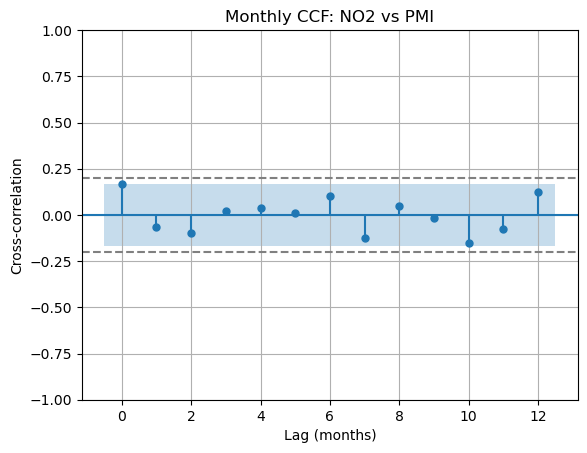

In [203]:
def ccf(pollutant):
    # Check & Enforce Stationarity 
    def make_stationary(series, name):
        result = adfuller(series.dropna())
        if result[1] > 0.05:
            print(f"{name} is non-stationary. Differencing applied.")
            return series.diff().dropna()
        else:
            print(f"{name} is stationary.")
            return series.dropna()

    pollution_diff = make_stationary(monthly_data[pollutant], "Monthly {pollutant}".format(pollutant=pollutant))
    pmi_diff = make_stationary(monthly_data['pmi'], "PMI")

    # Align Differenced Series After Differencing
    aligned = pd.concat([pollution_diff, pmi_diff], axis=1).dropna()

    # Plot CCF
    plt.figure(figsize=(10, 6))
    plot_ccf(aligned[pollutant], aligned['pmi'], lags=12)
    plt.title("Monthly CCF: {pollutant} vs PMI".format(pollutant=pollutant))
    plt.xlabel("Lag (months)")
    plt.ylabel("Cross-correlation")
    plt.axhline(y=0.2, linestyle='--', color='gray')
    plt.axhline(y=-0.2, linestyle='--', color='gray')
    plt.grid(True)
    plt.show()

# for col in pollution_df:
#     ccf(col)

ccf('NO2')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 1000x600 with 0 Axes>

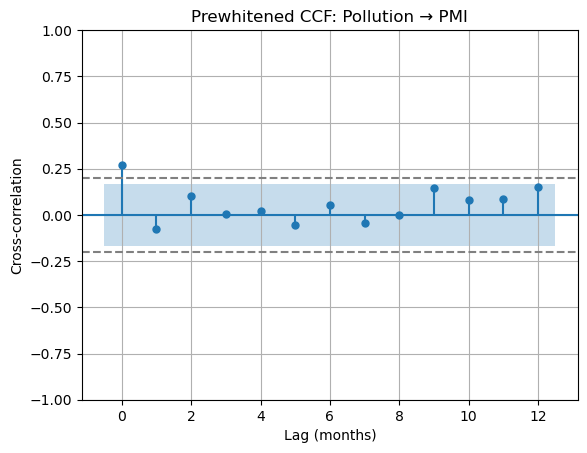

In [204]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf

# Ensure monthly_data has pollution and PMI
def prewhitening(pollutant):
    pollution = monthly_data[pollutant].dropna()
    pmi = monthly_data['pmi'].dropna()

    # Align the series
    data = pd.concat([pollution, pmi], axis=1).dropna()

    # Fit ARIMA model to pollution
    model = ARIMA(data[pollutant], order=(1, 0, 0))  # AR(1) for simplicity; refine this via AIC later
    model_fit = model.fit()

    # Extract residuals (white noise version of pollution)
    pollution_resid = model_fit.resid

    # Get the AR coefficient (phi_1)
    phi = model_fit.arparams[0]

    # Apply the same filter to PMI: x_t - phi * x_{t-1}
    pmi_filtered = data['pmi'].copy()
    pmi_filtered.iloc[1:] = pmi_filtered.iloc[1:] - phi * pmi_filtered.shift(1).iloc[1:]

    # Align residuals and filtered series
    aligned = pd.concat([pollution_resid, pmi_filtered], axis=1).dropna()
    aligned.columns = ['pollution_resid', 'pmi_filtered']

    plt.figure(figsize=(10, 6))
    plot_ccf(aligned['pollution_resid'], aligned['pmi_filtered'], lags=12)
    plt.title("Prewhitened CCF: Pollution → PMI")
    plt.xlabel("Lag (months)")
    plt.ylabel("Cross-correlation")
    plt.grid(True)
    plt.axhline(y=0.2, linestyle='--', color='gray')
    plt.axhline(y=-0.2, linestyle='--', color='gray')
    plt.show()


prewhitening('NO2')

In [205]:
# GRANGER-CAUSALITY

In [206]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import pandas as pd

# Assuming you already have monthly_data with pollution and pmi
data = monthly_data[['NO2', 'pmi']].dropna()

# 1. Make both series stationary (if not already done)
def make_stationary(series):
    result = adfuller(series.dropna())
    if result[1] > 0.05:
        return series.diff().dropna()
    else:
        return series.dropna()

pollution_stationary = make_stationary(data['NO2'])
pmi_stationary = make_stationary(data['pmi'])

# 2. Align differenced series
aligned = pd.concat([pollution_stationary, pmi_stationary], axis=1).dropna()
aligned.columns = ['NO2', 'pmi']

# 3. Run Granger causality test
# We test if pollution "Granger-causes" PMI
grangercausalitytests(aligned, maxlag=12, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3637  , p=0.5475  , df_denom=131, df_num=1
ssr based chi2 test:   chi2=0.3721  , p=0.5419  , df=1
likelihood ratio test: chi2=0.3716  , p=0.5422  , df=1
parameter F test:         F=0.3637  , p=0.5475  , df_denom=131, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5836  , p=0.5594  , df_denom=128, df_num=2
ssr based chi2 test:   chi2=1.2127  , p=0.5453  , df=2
likelihood ratio test: chi2=1.2072  , p=0.5468  , df=2
parameter F test:         F=0.5836  , p=0.5594  , df_denom=128, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4852  , p=0.6932  , df_denom=125, df_num=3
ssr based chi2 test:   chi2=1.5370  , p=0.6738  , df=3
likelihood ratio test: chi2=1.5281  , p=0.6758  , df=3
parameter F test:         F=0.4852  , p=0.6932  , df_denom=125, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6555  , p=0.6241  

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (0.3637433566344778, 0.547477341137335, 131.0, 1),
   'ssr_chi2test': (0.3720733571680918, 0.541876274309939, 1),
   'lrtest': (0.37155774951736475, 0.5421563832399705, 1),
   'params_ftest': (0.36374335663447277, 0.547477341137335, 131.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5835660467719638, 0.559382619687262, 128.0, 2),
   'ssr_chi2test': (1.2127231909479872, 0.5453314001374885, 2),
   'lrtest': (1.207227634037281, 0.5468319106008686, 2),
   'params_ftest': (0.5835660467719679, 0.559382619687262, 128.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.4851687010927805, 0.6931919431003264, 125.0, 3),
   'ssr_chi2test': (1.5370144450619285, 0.6737541385728858, 3),
   'lrtest': (1.5281347731879578, 0.6757922277751336, 3),
   'params_ftest': (0.4851687010927788, 0.6931919431003264, 125.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 